# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_70839/809774969.py:3: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_eeg_demo_data
from apm.run import run_measures, run_group_measures
from apm.analysis import (compute_avgs, compute_all_corrs, compute_corrs_to_feature,
                          compute_diffs_to_feature, unpack_corrs)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_all
from apm.plts.utils import make_axes
from apm.plts.settings import SAVE_EXT
from apm.methods import specparam, irasa, hurst, dfa, hjorth_complexity, lempelziv, app_entropy
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Define the data folder
folder = '/Users/tom/Data/VoytekLab/ExtractedSubsets/eeg_data'

In [5]:
# Define data field to extract from files
data_field = 'oz_rest_data'

In [6]:
# Define data information
fs = 500
n_seconds = 120

In [7]:
# Define times vector for data
times = create_times(n_seconds, fs)

In [8]:
# Add plot kwargs
dot_kwargs = {
    'alpha' : 0.75,
}

In [9]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '51_eeg_data'

## Load Data


In [10]:
# Get the list of available files
files = get_files(folder, select='.mat')

In [11]:
# FIX: temporarily drop subject which has a data quirk (wrong size array)
files.remove('1009.mat')

In [12]:
# Check the number of subjects
n_subjs = len(files)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 28


In [13]:
# Load data
data = load_eeg_demo_data(files, folder, data_field)

## Data Checks

In [14]:
# Set example data index
data_ind = 12

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


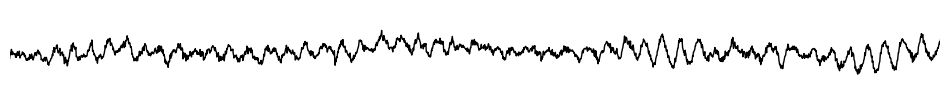

In [15]:
# Plot a segment of time series data
plot_time_series(times, data[data_ind, :], lw=1., xlim=[5, 10], figsize=(12, 1))
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + SAVE_EXT))

In [16]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[data_ind, :], fs, nperseg=2*fs, noverlap=fs)

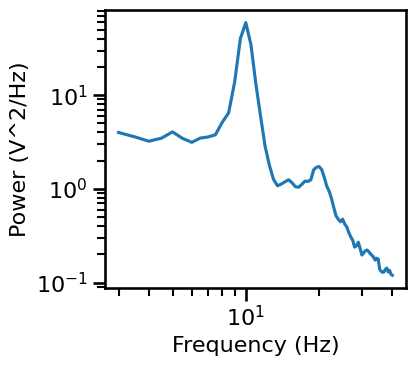

In [17]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]), figsize=(4.5, 4), 
                   save_fig=SAVE_FIG, file_name='rest_eeg_psd' + SAVE_EXT, file_path=FIGPATH)

## Compute Measures

### Aperiodic Methods

In [18]:
# General method settings
f_range = [3, 40]

In [19]:
# # Initialize specparam model
# fm = FOOOF(verbose=False)

In [20]:
# Define measures to apply, along with input parameters
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [21]:
# Compute measures of interest on the data
results = run_measures(data, measures)

In [127]:
# Compute correlations across all pairs of methods
all_corrs = compute_all_corrs(results)

In [23]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

### Peak Measures

In [79]:
# Define periodic measures to compute
peak_measures = {alpha_power : measures[specparam]}

# Compute periodic measures
peak_results = run_measures(data, peak_measures)

### Compare Exponent Measures

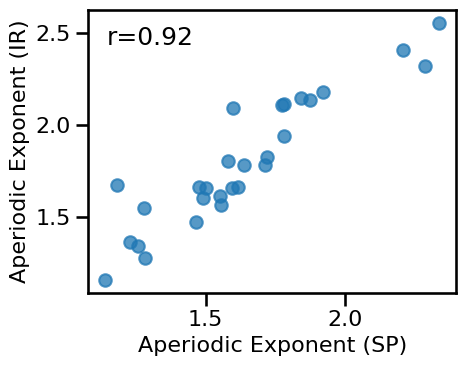

In [24]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs, figsize=(5, 4),
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)', tposition='tl',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + SAVE_EXT, file_path=FIGPATH)

In [25]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.920  CI[+0.771, +0.980],  p=0.000


### Compare Exponent to TS Measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


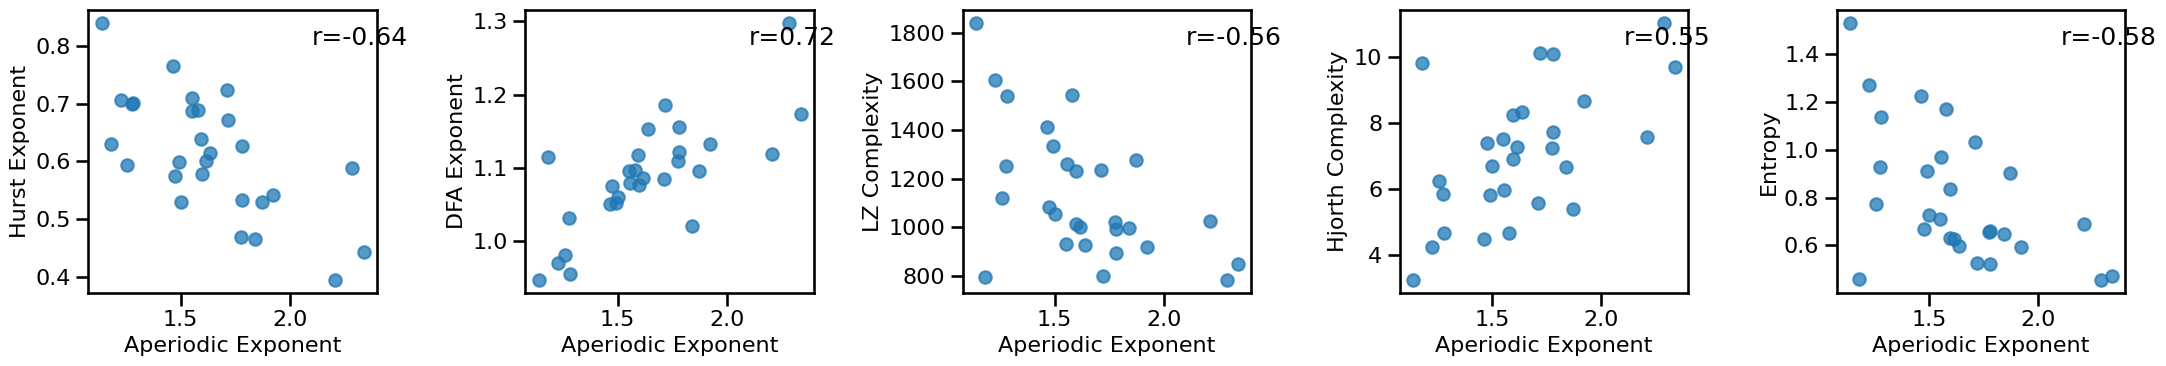

In [26]:
axes = make_axes(1, len(ts_measures), figsize=(22, 4), wspace=0.1)
plot_dots(results['specparam'], results['hurst'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hurst Exponent', ax=axes[0])
plot_dots(results['specparam'], results['dfa'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='DFA Exponent', ax=axes[1])
plot_dots(results['specparam'], results['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[2])
plot_dots(results['specparam'], results['hjorth_complexity'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[3])
plot_dots(results['specparam'], results['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Entropy', ax=axes[4])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_ts_scatters' + SAVE_EXT))

In [27]:
# Check the correlations between time series and exponent measures# Check the correlation
print('  SP-EXP & LZC:  ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  IR-EXP & LZC:  ', format_corr(*all_corrs['irasa']['lempelziv']))
print('  SP-EXP & ENT:  ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  IR-EXP & ENT:  ', format_corr(*all_corrs['irasa']['app_entropy']))

  SP-EXP & LZC:   r=-0.561  CI[-0.838, -0.149],  p=0.002
  IR-EXP & LZC:   r=-0.649  CI[-0.842, -0.333],  p=0.000
  SP-EXP & ENT:   r=-0.577  CI[-0.846, -0.183],  p=0.001
  IR-EXP & ENT:   r=-0.691  CI[-0.859, -0.418],  p=0.000


### Compare Time Series Measures to Each Other

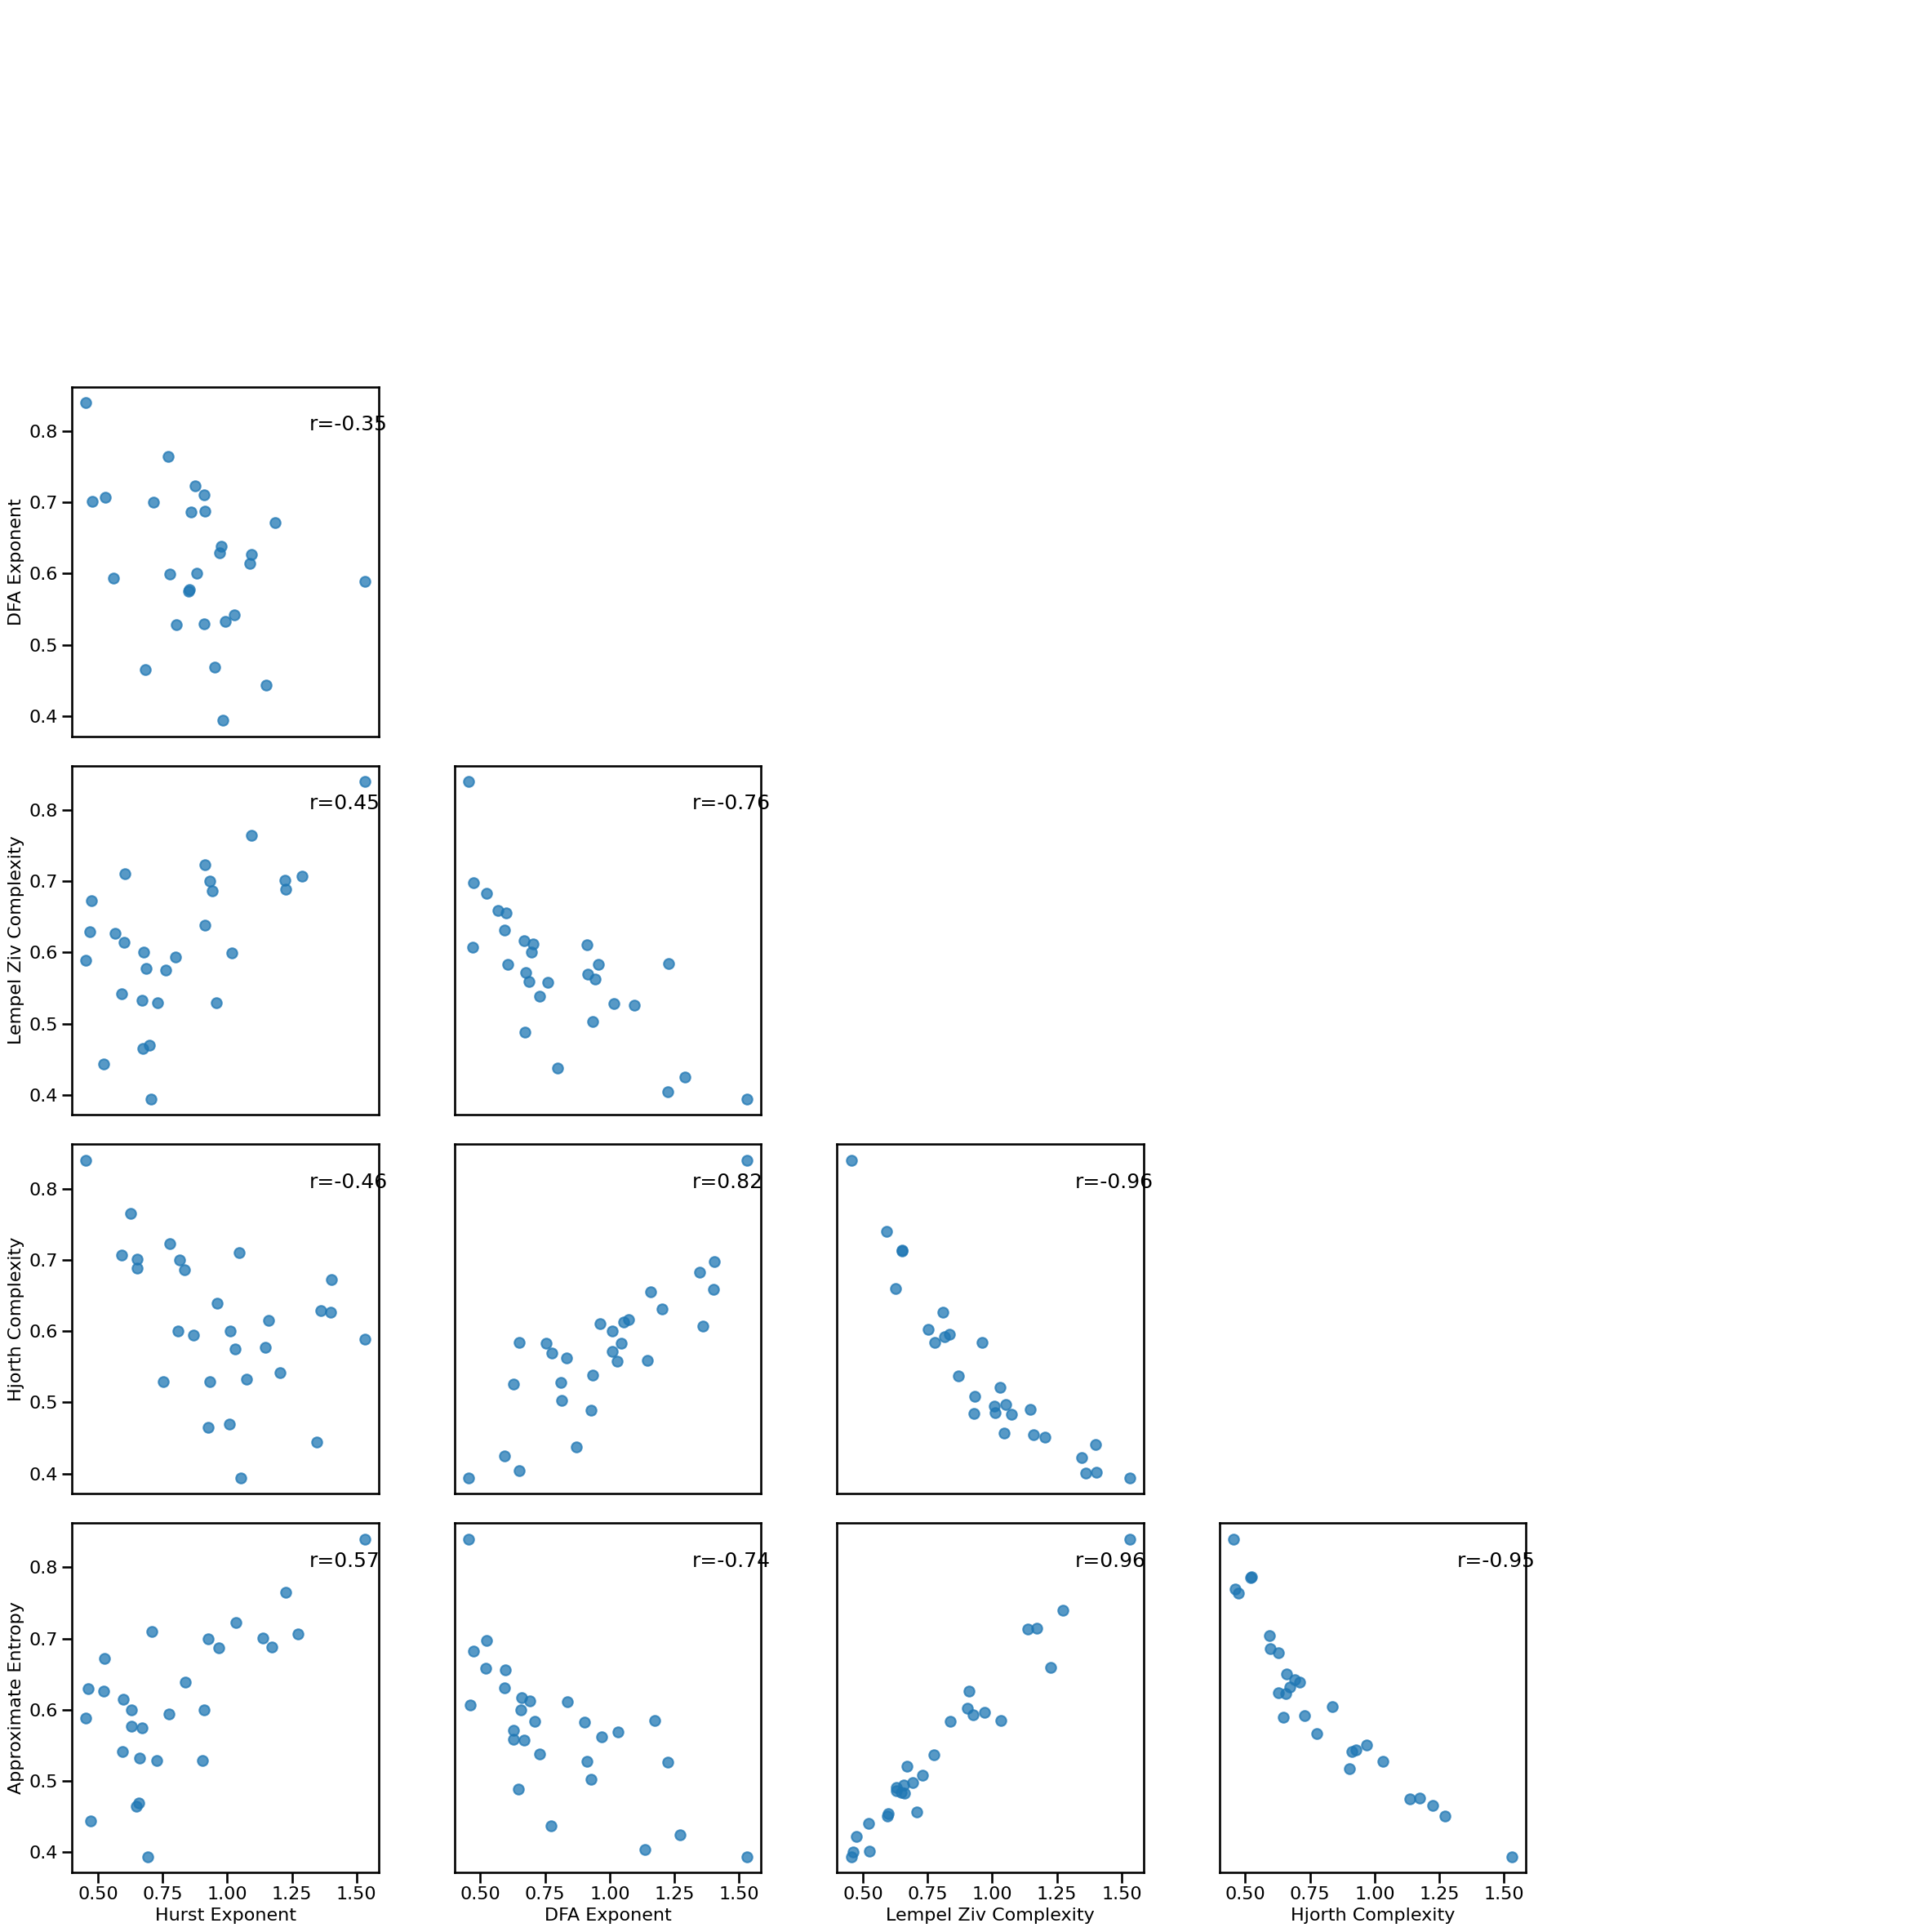

In [28]:
plot_results_all(results, ts_measures)

In [69]:
all_corrs_ts = deepcopy(all_corrs)
[all_corrs_ts.pop(meas) for meas in exp_measures];

In [71]:
all_corrs_mat = unpack_corrs(all_corrs_ts)

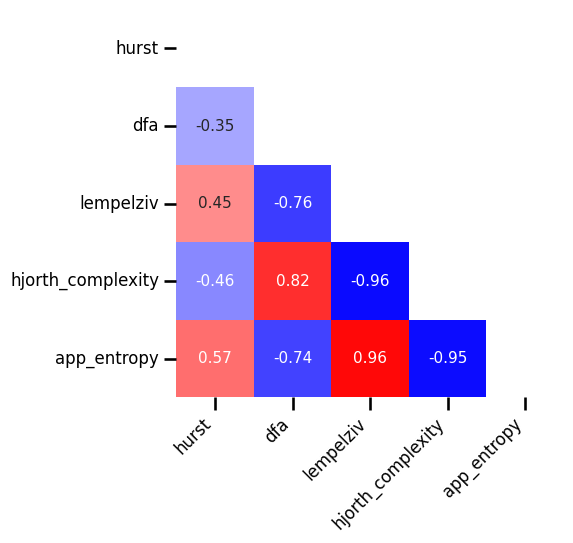

In [118]:
plot_corr_matrix(all_corrs_mat, xticklabels=labels, yticklabels=labels, cbar=False)
#plt.xticks(fontsize=12, rotation=45, ha='right') 
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_subjs' + SAVE_EXT))

In [141]:
exp_corrs_subjs = deepcopy(all_corrs['specparam'])
exp_corrs_subjs.pop('irasa');
exp_corrs_subjs = np.atleast_2d([exp_corrs_subjs[label][0] for label in labels]).T

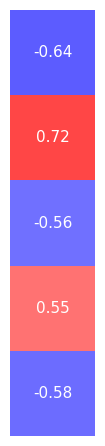

In [159]:
plot_corr_matrix(exp_corrs_subjs, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_corr_subjs' + SAVE_EXT))

### Compare to Alpha Power

In [34]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [35]:
# Compute differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [36]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     specparam           :   r=+0.159  CI[-0.297, +0.548],  p=0.418
     irasa               :   r=+0.218  CI[-0.227, +0.602],  p=0.265
     hurst               :   r=-0.691  CI[-0.871, -0.344],  p=0.000
     dfa                 :   r=-0.162  CI[-0.580, +0.268],  p=0.410
     lempelziv           :   r=+0.069  CI[-0.349, +0.482],  p=0.727
     hjorth_complexity   :   r=-0.039  CI[-0.458, +0.390],  p=0.842
     app_entropy         :   r=-0.025  CI[-0.439, +0.424],  p=0.901


In [152]:
alpha_corrs_ts = np.atleast_2d([alpha_corrs[label][0] for label in ts_measures]).T

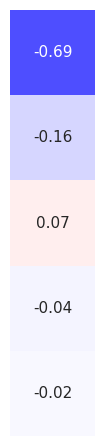

In [158]:
plot_corr_matrix(alpha_corrs_ts, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('alpha_corr_subjs' + SAVE_EXT))

## Topographies

In [37]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns

import mne
from mne.viz import plot_topomap

In [38]:
path = Path('/Users/tom/Desktop/apm_data/')

In [39]:
data1 = np.load(path / 'rtPB_extracted_block.npy')
data2 = np.load(path / 'PBA_extracted_block.npy')
group_data = np.vstack([data1, data2])

In [40]:
FS = 500

In [41]:
with open(path / 'ch_names.txt') as file:
    ch_names = [str(line.strip()) for line in file]

In [42]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names, FS, 'eeg')
info = info.set_montage(montage)

#### Compute Measures Across Channels

In [43]:
group_results = run_group_measures(group_data, measures)

In [44]:
group_avg = compute_avgs(group_results)

#### Exponent Topograghies

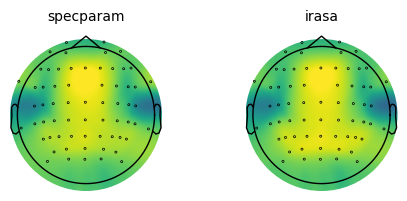

In [45]:
axes = make_axes(1, len(exp_measures), figsize=(5, 3), wspace=0.55)
for measure, ax in zip(exp_measures, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_topos' + SAVE_EXT))

#### Time Series Measure Topographies

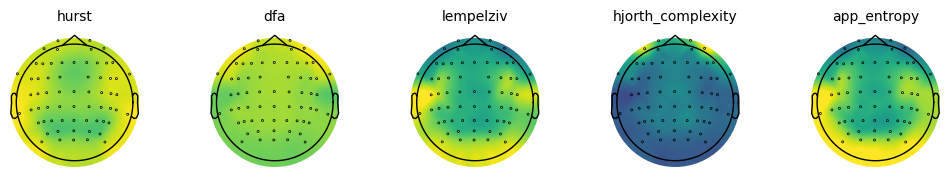

In [46]:
axes = make_axes(1, len(ts_measures), figsize=(12, 3), wspace=0.55)
for measure, ax in zip(ts_measures, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_topos' + SAVE_EXT))

In [47]:
group_avg_ts = deepcopy(group_avg)
[group_avg_ts.pop(meas) for meas in exp_measures];

In [48]:
group_corrs = compute_all_corrs(group_avg_ts)

In [49]:
group_corrs_mat = unpack_corrs(group_corrs)

In [164]:
mask = np.triu(group_corrs_mat)
labels = list(group_corrs.keys())
short_labels = ['Hurst', 'DFA', 'LZC', 'HJC', 'AppE']

In [52]:
group_corrs_mat = unpack_corrs(group_corrs)

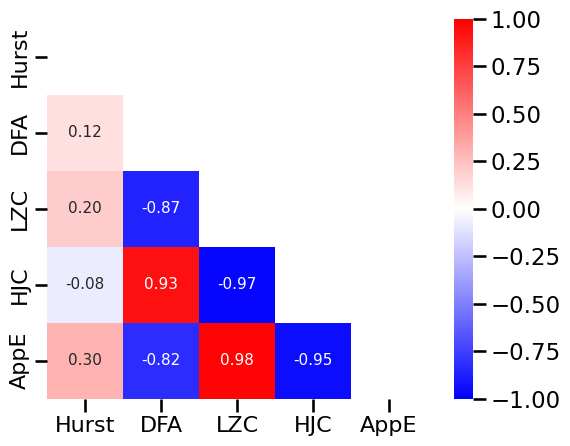

In [170]:
plot_corr_matrix(group_corrs_mat, xticklabels=short_labels, yticklabels=short_labels)
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat' + SAVE_EXT))

In [171]:
group_exp_corrs = compute_corrs_to_feature(group_avg_ts, group_avg['specparam'])

In [56]:
exp_corr_mat = np.atleast_2d([group_exp_corrs[label][0] for label in group_exp_corrs]).T

In [57]:
#plot_corr_matrix(exp_corr_mat, cbar=False, xticklabels=[], yticklabels=[], square=True)

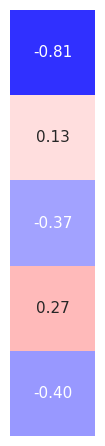

In [177]:
plot_corr_matrix(exp_corr_mat, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_corr_space' + SAVE_EXT))

## Alpha Power Topography

In [59]:
group_results_peaks = run_group_measures(group_data, peak_measures)

In [60]:
group_results_peaks['alpha_power'] = np.log10(group_results_peaks['alpha_power'])

In [61]:
group_avg_peaks = compute_avgs(group_results_peaks)

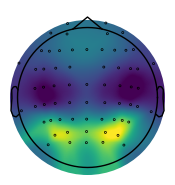

In [62]:
plot_topomap(group_avg_peaks['alpha_power'], info, cmap=cm.viridis,
             contours=0, size=2, vlim=(-11.5, -10.5), show=False)
if True: plt.savefig(FIGPATH / ('alpha_topo' + SAVE_EXT))

In [63]:
# Compute correlations between aperiodic measures and alpha power
group_alpha_corrs = compute_corrs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [64]:
# Compute differences between correlations between aperiodic measures and alpha power
group_alpha_corr_diffs = compute_diffs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [65]:
alpha_corr_mat = np.atleast_2d([group_alpha_corrs[label][0] for label in group_alpha_corrs]).T

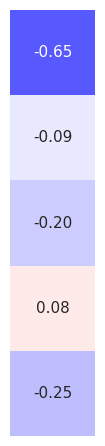

In [174]:
plot_corr_matrix(alpha_corr_mat, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('alpha_corr_space' + SAVE_EXT))

## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.